In [ ]:
import sys
sys.path.append("..")

In [2]:
import torch
import math
import matplotlib.pyplot as plt

In [3]:
def precompute_freqs_rope(model_dim, n_attn_heads, context_length):
    theta = 10000.0
    head_dim = model_dim // n_attn_heads

    pos = torch.arange(context_length).unsqueeze(1)
    dim = torch.arange(0, head_dim, step=2).unsqueeze(0)

    freqs = pos * torch.exp(dim * -math.log(theta) / head_dim)
    freqs_cos = torch.cos(freqs)  # real part
    freqs_sin = torch.sin(freqs)  # imaginary part
    freqs_cos = freqs_cos.view(1, 1, *freqs_cos.shape)
    freqs_sin = freqs_sin.view(1, 1, *freqs_sin.shape)
    return freqs_cos, freqs_sin

In [4]:
def apply_rotary_emb(
    x: torch.Tensor,
    freqs_cos: torch.Tensor,
    freqs_sin: torch.Tensor
) -> tuple[torch.Tensor, torch.Tensor]:

    # reshape q and k to match the complex representation
    r, i = x.float().reshape(x.shape[:-1] + (-1, 2)).unbind(-1)

    # apply rotation using real numbers
    x_a = r * freqs_cos - i * freqs_sin
    x_b = i * freqs_cos + r * freqs_sin

    # flatten last two dimensions
    out = torch.stack([x_a, x_b], dim=-1).flatten(3)

    return out.type_as(x)

In [5]:
freqs_cos, freqs_sin = precompute_freqs_rope(4096, 32, 4096)

In [6]:
freqs_cos.shape

torch.Size([1, 1, 4096, 64])

In [7]:
x = torch.ones(1, 32, 4096, 4096 // 32)

In [8]:
y = apply_rotary_emb(x, freqs_cos, freqs_sin)

In [9]:
y_ = y[0,0,:,:]

In [10]:
y_.shape

torch.Size([4096, 128])

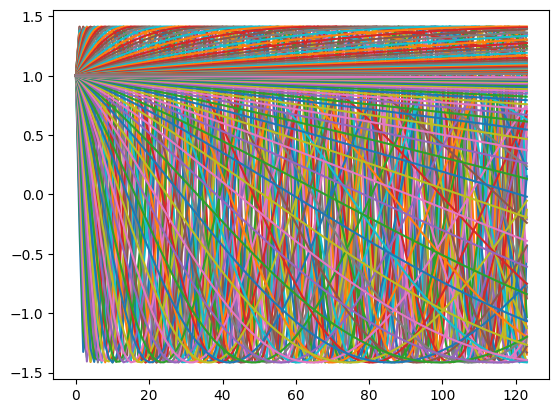

In [12]:
for i in range(y_.shape[-1]):
    plt.plot(y_[:124,i])
plt.savefig('rope.png')